In [28]:
from PIL import Image
import requests
from io import BytesIO
from map_boxes import mean_average_precision_for_boxes
import pandas as pd
import numpy as np
import json
from tqdm import tqdm
from pycocotools.coco import COCO
from matplotlib.colors import ListedColormap
import matplotlib
import tqdm
import os
from PIL import Image, ImageEnhance, ImageFilter
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as img
import matplotlib.colors as mcolors
colorlist = ['#FF0000','#FF8000','#FFFF00','#80FF00','#00FF00','#00FFFF','#0000FF','#7F00FF','#FF00FF','#FF007F']

In [2]:
GT_JSON = '../dataset/train.json' # 기본 json
PRED_CSV = '../sample_submission/train_sample.csv'
LABEL_NAME = ["General trash", "Paper", "Paper pack", "Metal", 
              "Glass", "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing"]
image_dir = '../dataset/'

In [3]:
'''
[
    [file_name 1, label_index, x_min, x_max, y_min, y_max], 
]
'''   
coco = COCO(GT_JSON) # 형식
'''
    GT_JSON: valid set json file path
    현재 예시에서는 train.json을 임의로 valid set으로 사용
    PRED_CSV: 위의 valid set을 inference한 submission file
'''
# load ground truth
with open(GT_JSON, 'r') as outfile:
    gt_json = (json.load(outfile))
# with open(GT_plus_json, 'w') as outfile:
#     json.dump(data, outfile)

loading annotations into memory...
Done (t=0.08s)
creating index...
index created!


In [4]:
gt_json['annotations'][5159]

{'image_id': 1063,
 'category_id': 0,
 'area': 0.56,
 'bbox': [647.8, 460.2, 0.7, 0.8],
 'iscrowd': 0,
 'id': 5159}

In [5]:
del gt_json['annotations'][5159]

In [6]:
gt_json['annotations'].sort(key=lambda x:x['image_id'])
for i in range(len(gt_json['annotations'])):
    gt_json['annotations'][i]['id']=i

file_path = '/opt/ml/dataset_3/train_new.json'
with open(file_path, 'w') as outfile:
    json.dump(gt_json, outfile)

In [7]:
GT_JSON = '/opt/ml/dataset_3/train_new.json'  
coco = COCO(GT_JSON) # 형식
# load ground truth
with open(GT_JSON, 'r') as outfile:
    gt_json = (json.load(outfile))

loading annotations into memory...
Done (t=0.17s)
creating index...
index created!


In [8]:
'''
[{'width': 1024,
  'height': 1024,
  'file_name': 'train/4882.jpg',
  'license': 0,
  'flickr_url': None,
  'coco_url': None,
  'date_captured': '2020-12-23 16:20:30',
  'id': 4882}]
  '''

"\n[{'width': 1024,\n  'height': 1024,\n  'file_name': 'train/4882.jpg',\n  'license': 0,\n  'flickr_url': None,\n  'coco_url': None,\n  'date_captured': '2020-12-23 16:20:30',\n  'id': 4882}]\n  "

In [9]:
#"Paper pack", "Metal", "Glass", "Plastic", "Styrofoam", "Battery", "Clothing" 2,3,4,5,6,8,9
# 각 이미지별 annotation 저장
def anno(class_name,label_num):
    for image_id in coco.getImgIds():
        image_info = coco.loadImgs(image_id)[0]
        annotation_id = coco.getAnnIds(imgIds=image_info['id'])
        annotation_info_list = coco.loadAnns(annotation_id)
        img_test = Image.open(image_dir+image_info['file_name'])
        for i in range(len(annotation_info_list)):
            if annotation_info_list[i]['category_id']==label_num:
                xmin, w, ymin, h = annotation_info_list[i]['bbox'][0], annotation_info_list[i]['bbox'][2], annotation_info_list[i]['bbox'][1], annotation_info_list[i]['bbox'][3]
                class_name.append((image_id,w,h))
    return class_name

In [10]:
a=[]
b=[]
c=[]
d=[]
e=[]
f=[]
g=[]
h=[]
i=[]
generaltrash = anno(a,0)
paper=[]
paperpack = anno(b,2)
metal = anno(c,3)
glass = anno(d,4)
plastic = anno(e,5)
styrofoam = anno(f,6)
plasticbag = anno(g,7)
battery = anno(h,8)
cloth = anno(i,9)

In [11]:
def base(image):
    return image
def make_gray_image(image):
    image = image.convert('L')         
    return image
def color_reverse(image):
    for i in range(0,image.size[0]):
        for j in range(0,image.size[1]):
            rgb = image.getpixel((i,j))
            rgb_r = (255-rgb[0], 255-rgb[1], 255-rgb[2])
            image.putpixel((i,j), rgb_r)
    return image
def blur(image):
    enhancer = ImageEnhance.Color(image)
    color_factor = np.random.uniform(0.5, 1.5)
    img = enhancer.enhance(color_factor)
    img = img.filter(ImageFilter.GaussianBlur(radius=2))
    
    return img
def edge(image):
    img_edge = image.filter(ImageFilter.EDGE_ENHANCE)
    return img_edge

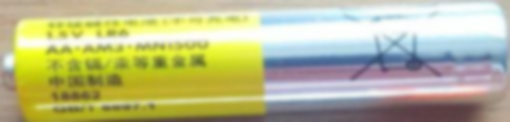

In [12]:
img = Image.open("../Battery/Battery_1.jpg")
# 색상 변경
color_r = np.random.randint(0,3,1)
color_fun = [base, color_reverse, make_gray_image]
# blur, edge
extra_r = np.random.randint(0,3,1)
extra_fun = [base, edge, blur]
img = color_fun[color_r[0]](img)#
img = extra_fun[extra_r[0]](img)
img.show()

In [13]:
def paste_image(gt_json, background, annotation, label_num, direction,image_id):
    gt_json = gt_json #기본 gt json
    anno = annotation

    # 임의의 다운 size 선택
    size = [1.5,2,2.5]
    size_r = np.random.choice(size,1)
    # 색상 변경
    color_r = np.random.randint(0,3,1)
    color_fun = [base, color_reverse, make_gray_image]
    # blur, edge
    extra_r = np.random.randint(0,3,1)
    extra_fun = [base, edge, blur]
    r= np.random.randint(1,len(anno),1) #각 이미지 아이디 랜덤으로 뽑기

    image_dir = '/opt/ml/dataset_3/train/'
    if not os.path.exists(image_dir):
        os.makedirs(image_dir)

    img2_dir = "../"+LABEL_NAME[label_num]+"/"
    image1 = background
    image2 = Image.open(img2_dir+LABEL_NAME[label_num]+'_'+str(r[0])+'.jpg')
    image2 = image2.resize((int(image2.width/size_r),int(image2.height/size_r)))
    image2 = color_fun[color_r[0]](image2)
    image2 = extra_fun[color_r[0]](image2)

    if direction== 'left_up':
        bbox=[float(0), float(0), (anno[r[0]-1][1]/size_r)[0], (anno[r[0]-1][2]/size_r)[0]]
    elif direction == 'left_down':
        bbox=[float(0), (1024-(anno[r[0]-1][2]/size_r))[0], (anno[r[0]-1][1]/size_r)[0], (anno[r[0]-1][2]/size_r)[0]]
    elif direction =='right_up':
        bbox=[(1024-(anno[r[0]-1][1]/size_r))[0], float(0), (anno[r[0]-1][1]/size_r)[0], (anno[r[0]-1][2]/size_r)[0]]
    elif direction == 'right_down':
        bbox = [(1024-(anno[r[0]-1][1]/size_r))[0], (1024-(anno[r[0]-1][2]/size_r))[0], (anno[r[0]-1][1]/size_r)[0], (anno[r[0]-1][2]/size_r)[0]]
    elif direction == 'center':
        bbox = [(512-anno[r[0]-1][1]/(size_r*2))[0],(512-anno[r[0]-1][2]/(size_r*2))[0],(anno[r[0]-1][1]/size_r)[0], (anno[r[0]-1][2]/size_r)[0]]    
    
    gt_json['images'].append({
    'width': 1024,
    'height': 1024,
    'file_name': 'train/'+str(image_id)+'.jpg',
    'license': 0,
    'flickr_url': None,
    'coco_url': None,
    'date_captured': '2020-12-23 16:20:30',
    'id': image_id
    })
    gt_json['annotations'].append({
    'image_id': image_id,
    'category_id': label_num,
    'area': (np.round(anno[r[0]-1][1]*anno[r[0]-1][2]/(size_r**2),2))[0],
    'bbox': bbox,
    'iscrowd': 0,
    'id': 9
    })
    
    image1.paste(image2, (int(bbox[0]), int(bbox[1])))
    image1.save(image_dir+str(image_id)+'.jpg')

In [14]:
classname=[generaltrash, paper, paperpack, metal, glass, plastic, styrofoam, plasticbag, battery, cloth]

In [15]:
for  i in range(4883, 4883+300):
    img_size = (1024, 1024)
    black_img = Image.new('RGB', img_size, color='black')
    paste_image(gt_json, black_img, classname[0], 0, 'center',i)
    paste_image(gt_json, black_img, classname[2], 2, 'left_up',i)
    paste_image(gt_json, black_img, classname[3], 3, 'left_down',i)
    paste_image(gt_json, black_img, classname[4], 4, 'right_up',i)
    paste_image(gt_json, black_img, classname[5], 5, 'right_down',i)

for  i in range(4883+300, 4883+600):
    img_size = (1024, 1024)
    black_img = Image.new('RGB', img_size, color='black')
    paste_image(gt_json, black_img, classname[2], 2, 'center',i)
    paste_image(gt_json, black_img, classname[3], 3, 'left_up',i)
    paste_image(gt_json, black_img, classname[4], 4, 'left_down',i)
    paste_image(gt_json, black_img, classname[6], 6, 'right_up',i)
    paste_image(gt_json, black_img, classname[8], 8, 'right_down',i)

for  i in range(4883+600, 4883+900):
    img_size = (1024, 1024)
    black_img = Image.new('RGB', img_size, color='black')
    paste_image(gt_json, black_img, classname[3], 3, 'center',i)
    paste_image(gt_json, black_img, classname[4], 4, 'left_up',i)
    paste_image(gt_json, black_img, classname[5], 5, 'left_down',i)
    paste_image(gt_json, black_img, classname[7], 7, 'right_up',i)
    paste_image(gt_json, black_img, classname[8], 8, 'right_down',i)

for  i in range(4883+900, 4883+1200):
    img_size = (1024, 1024)
    black_img = Image.new('RGB', img_size, color='black')
    paste_image(gt_json, black_img, classname[4], 4, 'center',i)
    paste_image(gt_json, black_img, classname[6], 6, 'left_up',i)
    paste_image(gt_json, black_img, classname[7], 7, 'left_down',i)
    paste_image(gt_json, black_img, classname[8], 8, 'right_up',i)
    paste_image(gt_json, black_img, classname[9], 9, 'right_down',i)

for  i in range(4883+1200, 4883+1500):
    img_size = (1024, 1024)
    black_img = Image.new('RGB', img_size, color='black')
    paste_image(gt_json, black_img, classname[5], 5, 'center',i)
    paste_image(gt_json, black_img, classname[7], 7, 'left_up',i)
    paste_image(gt_json, black_img, classname[8], 8, 'left_down',i)
    paste_image(gt_json, black_img, classname[9], 9, 'right_up',i)
    paste_image(gt_json, black_img, classname[0], 0, 'right_down',i)

for  i in range(4883+1500, 4883+1800):
    img_size = (1024, 1024)
    black_img = Image.new('RGB', img_size, color='black')
    paste_image(gt_json, black_img, classname[7], 7, 'center',i)
    paste_image(gt_json, black_img, classname[8], 8, 'left_up',i)
    paste_image(gt_json, black_img, classname[2], 2, 'left_down',i)
    paste_image(gt_json, black_img, classname[0], 0, 'right_up',i)
    paste_image(gt_json, black_img, classname[3], 3, 'right_down',i)

for  i in range(4883+1800, 4883+2100):
    img_size = (1024, 1024)
    black_img = Image.new('RGB', img_size, color='black')
    paste_image(gt_json, black_img, classname[3], 3, 'center',i)
    paste_image(gt_json, black_img, classname[2], 2, 'left_up',i)
    paste_image(gt_json, black_img, classname[5], 5, 'left_down',i)
    paste_image(gt_json, black_img, classname[8], 8, 'right_up',i)
    paste_image(gt_json, black_img, classname[9], 9, 'right_down',i)

for  i in range(4883+2100, 4883+2400):
    img_size = (1024, 1024)
    black_img = Image.new('RGB', img_size, color='black')
    paste_image(gt_json, black_img, classname[9], 9, 'center',i)
    paste_image(gt_json, black_img, classname[0], 0, 'left_up',i)
    paste_image(gt_json, black_img, classname[8], 8, 'left_down',i)
    paste_image(gt_json, black_img, classname[5], 5, 'right_up',i)
    paste_image(gt_json, black_img, classname[3], 3, 'right_down',i)

for  i in range(4883+2400, 4883+2700):
    img_size = (1024, 1024)
    black_img = Image.new('RGB', img_size, color='black')
    paste_image(gt_json, black_img, classname[2], 2, 'center',i)
    paste_image(gt_json, black_img, classname[6], 6, 'left_up',i)
    paste_image(gt_json, black_img, classname[0], 0, 'left_down',i)
    paste_image(gt_json, black_img, classname[8], 8, 'right_up',i)
    paste_image(gt_json, black_img, classname[5], 5, 'right_down',i)

for  i in range(4883+2700, 4883+3000):
    img_size = (1024, 1024)
    black_img = Image.new('RGB', img_size, color='black')
    paste_image(gt_json, black_img, classname[5], 5, 'center',i)
    paste_image(gt_json, black_img, classname[4], 4, 'left_up',i)
    paste_image(gt_json, black_img, classname[3], 3, 'left_down',i)
    paste_image(gt_json, black_img, classname[0], 0, 'right_up',i)
    paste_image(gt_json, black_img, classname[2], 2, 'right_down',i)

for  i in range(4883+3000, 4883+3300):
    img_size = (1024, 1024)
    black_img = Image.new('RGB', img_size, color='black')
    paste_image(gt_json, black_img, classname[9], 9, 'center',i)
    paste_image(gt_json, black_img, classname[5], 5, 'left_up',i)
    paste_image(gt_json, black_img, classname[3], 3, 'left_down',i)
    paste_image(gt_json, black_img, classname[2], 2, 'right_up',i)
    paste_image(gt_json, black_img, classname[0], 0, 'right_down',i)

for  i in range(4883+3300, 4883+3600):
    img_size = (1024, 1024)
    black_img = Image.new('RGB', img_size, color='black')
    paste_image(gt_json, black_img, classname[8], 8, 'center',i)
    paste_image(gt_json, black_img, classname[2], 2, 'left_up',i)
    paste_image(gt_json, black_img, classname[3], 3, 'left_down',i)
    paste_image(gt_json, black_img, classname[9], 9, 'right_up',i)
    paste_image(gt_json, black_img, classname[9], 9, 'right_down',i)

for  i in range(4883+3600, 4883+3900):
    img_size = (1024, 1024)
    black_img = Image.new('RGB', img_size, color='black')
    paste_image(gt_json, black_img, classname[6], 6, 'center',i)
    paste_image(gt_json, black_img, classname[2], 2, 'left_up',i)
    paste_image(gt_json, black_img, classname[3], 3, 'left_down',i)
    paste_image(gt_json, black_img, classname[6], 6, 'right_up',i)
    paste_image(gt_json, black_img, classname[6], 6, 'right_down',i)

for  i in range(4883+3900, 4883+4200):
    img_size = (1024, 1024)
    black_img = Image.new('RGB', img_size, color='black')
    paste_image(gt_json, black_img, classname[6], 6, 'center',i)
    paste_image(gt_json, black_img, classname[4], 4, 'left_up',i)
    paste_image(gt_json, black_img, classname[6], 6, 'left_down',i)
    paste_image(gt_json, black_img, classname[4], 4, 'right_up',i)
    paste_image(gt_json, black_img, classname[4], 4, 'right_down',i)

for  i in range(4883+4200, 4883+4500):
    img_size = (1024, 1024)
    black_img = Image.new('RGB', img_size, color='black')
    paste_image(gt_json, black_img, classname[2], 2, 'center',i)
    paste_image(gt_json, black_img, classname[3], 3, 'left_up',i)
    paste_image(gt_json, black_img, classname[4], 4, 'left_down',i)
    paste_image(gt_json, black_img, classname[5], 5, 'right_up',i)
    paste_image(gt_json, black_img, classname[4], 5, 'right_down',i)

for  i in range(4883+4500, 4883+4800):
    img_size = (1024, 1024)
    black_img = Image.new('RGB', img_size, color='black')
    paste_image(gt_json, black_img, classname[5], 5, 'center',i)
    paste_image(gt_json, black_img, classname[2], 2, 'left_up',i)
    paste_image(gt_json, black_img, classname[3], 3, 'left_down',i)
    paste_image(gt_json, black_img, classname[4], 4, 'right_up',i)
    paste_image(gt_json, black_img, classname[2], 2, 'right_down',i)

for  i in range(4883+4800, 4883+5100):
    img_size = (1024, 1024)
    black_img = Image.new('RGB', img_size, color='black')
    paste_image(gt_json, black_img, classname[2], 2, 'center',i)
    paste_image(gt_json, black_img, classname[8], 8, 'left_up',i)
    paste_image(gt_json, black_img, classname[9], 9, 'left_down',i)
    paste_image(gt_json, black_img, classname[9], 9, 'right_up',i)
    paste_image(gt_json, black_img, classname[3], 3, 'right_down',i)

for  i in range(4883+5100, 4883+5400):
    img_size = (1024, 1024)
    black_img = Image.new('RGB', img_size, color='black')
    paste_image(gt_json, black_img, classname[9], 9, 'center',i)
    paste_image(gt_json, black_img, classname[8], 8, 'left_up',i)
    paste_image(gt_json, black_img, classname[3], 3, 'left_down',i)
    paste_image(gt_json, black_img, classname[4], 4, 'right_up',i)
    paste_image(gt_json, black_img, classname[2], 2, 'right_down',i)

for  i in range(4883+5400, 4883+5700):
    img_size = (1024, 1024)
    black_img = Image.new('RGB', img_size, color='black')
    paste_image(gt_json, black_img, classname[3], 3, 'center',i)
    paste_image(gt_json, black_img, classname[4], 4, 'left_up',i)
    paste_image(gt_json, black_img, classname[9], 9, 'left_down',i)
    paste_image(gt_json, black_img, classname[8], 8, 'right_up',i)
    paste_image(gt_json, black_img, classname[6], 6, 'right_down',i)

for  i in range(4883+5700, 4883+6000):
    img_size = (1024, 1024)
    black_img = Image.new('RGB', img_size, color='black')
    paste_image(gt_json, black_img, classname[6], 6, 'center',i)
    paste_image(gt_json, black_img, classname[3], 3, 'left_up',i)
    paste_image(gt_json, black_img, classname[4], 4, 'left_down',i)
    paste_image(gt_json, black_img, classname[9], 9, 'right_up',i)
    paste_image(gt_json, black_img, classname[8], 8, 'right_down',i)

for  i in range(4883+6000, 4883+6300):
    img_size = (1024, 1024)
    black_img = Image.new('RGB', img_size, color='black')
    paste_image(gt_json, black_img, classname[6], 6, 'center',i)
    paste_image(gt_json, black_img, classname[0], 0, 'left_up',i)
    paste_image(gt_json, black_img, classname[6], 6, 'left_down',i)
    paste_image(gt_json, black_img, classname[8], 8, 'right_up',i)
    paste_image(gt_json, black_img, classname[9], 9, 'right_down',i)

for  i in range(4883+6300, 4883+6600):
    img_size = (1024, 1024)
    black_img = Image.new('RGB', img_size, color='black')
    paste_image(gt_json, black_img, classname[2], 2, 'center',i)
    paste_image(gt_json, black_img, classname[2], 2, 'left_up',i)
    paste_image(gt_json, black_img, classname[3], 3, 'left_down',i)
    paste_image(gt_json, black_img, classname[4], 4, 'right_up',i)
    paste_image(gt_json, black_img, classname[5], 5, 'right_down',i)

for  i in range(4883+6600, 4883+6900):
    img_size = (1024, 1024)
    black_img = Image.new('RGB', img_size, color='black')
    paste_image(gt_json, black_img, classname[8], 8, 'center',i)
    paste_image(gt_json, black_img, classname[9], 9, 'left_up',i)
    paste_image(gt_json, black_img, classname[2], 2, 'left_down',i)
    paste_image(gt_json, black_img, classname[3], 3, 'right_up',i)
    paste_image(gt_json, black_img, classname[8], 8, 'right_down',i)

for  i in range(4883+6900, 4883+7200):
    img_size = (1024, 1024)
    black_img = Image.new('RGB', img_size, color='black')
    paste_image(gt_json, black_img, classname[4], 4, 'center',i)
    paste_image(gt_json, black_img, classname[6], 6, 'left_up',i)
    paste_image(gt_json, black_img, classname[8], 8, 'left_down',i)
    paste_image(gt_json, black_img, classname[9], 9, 'right_up',i)
    paste_image(gt_json, black_img, classname[2], 2, 'right_down',i)

for  i in range(4883+7200, 4883+7500):
    img_size = (1024, 1024)
    black_img = Image.new('RGB', img_size, color='black')
    paste_image(gt_json, black_img, classname[6], 6, 'center',i)
    paste_image(gt_json, black_img, classname[6], 6, 'left_up',i)
    paste_image(gt_json, black_img, classname[8], 8, 'left_down',i)
    paste_image(gt_json, black_img, classname[8], 8, 'right_up',i)
    paste_image(gt_json, black_img, classname[9], 9, 'right_down',i)

for  i in range(4883+7500, 4883+7800):
    img_size = (1024, 1024)
    black_img = Image.new('RGB', img_size, color='black')
    paste_image(gt_json, black_img, classname[9], 9, 'center',i)
    paste_image(gt_json, black_img, classname[9], 9, 'left_up',i)
    paste_image(gt_json, black_img, classname[9], 9, 'left_down',i)
    paste_image(gt_json, black_img, classname[5], 5, 'right_up',i)
    paste_image(gt_json, black_img, classname[6], 6, 'right_down',i)

In [50]:
# kkk =[[0,2,3,4,5],[2,3,4,6,8],[3,4,5,7,8],[4,6,7,8,9],[5,7,8,9,0],[7,8,2,0,3],[3,2,5,8,9],[9,0,8,5,3],[2,6,0,8,5],[5,4,3,0,2],[9,5,3,2,0],
#       [8,2,3,9,9],[6,2,3,6,6],[6,4,6,4,4],[2,3,4,5,4],[5,2,3,4,2],[2,8,9,9,3],[9,8,3,4,2],[3,4,9,8,6],[6,3,4,9,8],
#       [6,0,6,8,9],[2,2,3,4,5],[8,9,2,3,8],[4,6,8,9,2],[6,6,8,8,9],[9,9,9,5,6]]

In [51]:
# num_dict ={0:0,1:0,2:0,3:0,4:0,5:0,6:0,7:0,8:0,9:0}
# for i in range(len(kkk)):
#     for j in range(len(kkk[0])):
#         for k in range(10):
#             if kkk[i][j]==k:
#                 num_dict[k]+=1
            

In [16]:
gt_json['annotations'].sort(key=lambda x:x['image_id'])
for i in range(len(gt_json['annotations'])):
    gt_json['annotations'][i]['id']=i
file_path = '/opt/ml/dataset_3/train_new.json'
with open(file_path, 'w') as outfile:
    json.dump(gt_json, outfile)

In [20]:
coco = COCO(file_path)
max = 0
sum = 0
class_dict ={0:0,1:0,2:0,3:0,4:0,5:0,6:0,7:0,8:0,9:0}
for image_id in coco.getImgIds():
        
    image_info = coco.loadImgs(image_id)[0]
    annotation_id = coco.getAnnIds(imgIds=image_info['id'])
    annotation_info_list = coco.loadAnns(annotation_id)
    
    if len(annotation_info_list) > max:
        max = len(annotation_info_list)
    sum += len(annotation_info_list)
    for i in range(len(annotation_info_list)):
            for j in range(10):
                if annotation_info_list[i]['category_id']==j:
                     class_dict[j] +=1

print('이미지 사이즈:','[',image_info['width'],',',image_info['height'],']') 
print('이미지 클래스 개수:', len(LABEL_NAME))
print('각 클래스별 개수: ',class_dict)     
print('한 이미지의 최대 박스개수 : ',max)
print('전체 박스 개수: ', sum)


loading annotations into memory...
Done (t=0.41s)
creating index...
index created!
이미지 사이즈: [ 1024 , 1024 ]
이미지 클래스 개수: 10
각 클래스별 개수:  {0: 6365, 1: 6352, 2: 6297, 3: 6336, 4: 5482, 5: 6843, 6: 6063, 7: 6378, 8: 5859, 9: 6168}
한 이미지의 최대 박스개수 :  71
전체 박스 개수:  62143


In [29]:
def plot(id,box):
    image_info = coco.loadImgs(id)[0]
    annotation_id = coco.getAnnIds(imgIds=image_info['id'])
    annotation_info_list = coco.loadAnns(annotation_id)
    fig, ax =plt.subplots()
    img_test = img.imread('/opt/ml/dataset_3/'+image_info['file_name'])
    ax.imshow(img_test)
    if box ==True:
        for i in range(len(annotation_info_list)):
            for j in range(10):
                if annotation_info_list[i]['category_id']==j:
                    rect = patches.Rectangle((annotation_info_list[i]['bbox'][0], annotation_info_list[i]['bbox'][1]), annotation_info_list[i]['bbox'][2], annotation_info_list[i]['bbox'][3], linewidth=1, edgecolor=colorlist[j], facecolor='none')
                    ax.add_patch(rect)
                    plt.annotate(LABEL_NAME[annotation_info_list[i]['category_id']],[annotation_info_list[i]['bbox'][0],annotation_info_list[i]['bbox'][1]-15],color=colorlist[j], fontweight='bold')
    else:
         pass
    #plt.axis([0,image_info['width'],0,image_info['height']])
    plt.title(f'image_id : {id}')
    plt.show()